In [1]:
%load_ext autoreload
%autoreload 2


# Deep Learning Analysis

In [2]:
import json
import joblib
import lightning as L
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
from torchmetrics import MeanSquaredError
from torchvision import datasets
from utils.helper_classes import CancerDataModule, CancerDataset
from utils.models import BaseCancerRegressor, CancerDataAutoEncoder

In [3]:
cancer_df = pd.read_csv("../data/cleaned_feature_and_target_data.csv", index_col=0)
cna_columns = [col for col in cancer_df.columns if col.startswith("CNA")]
numeric_cols = ["SMOKING_PACK_YEARS"] + cna_columns
cancer_df[numeric_cols] = cancer_df[numeric_cols].astype(np.float32)
scaler = joblib.load(open("results/scaler.pkl", "rb"))
cancer_dm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler)
cancer_dm.setup()

In [4]:
with open('results/02/results.txt', 'r') as file:
    best_ae_model_path = file.readline().strip()

In [5]:
with open('results/02/best_trial_params.json', 'r') as json_file:
    best_model_params = json.load(json_file)

print(best_model_params)

{'latent_size': 38, 'n_layers': 2, 'dropout': 0.08362845598146633}


In [6]:
cancer_autoencoder = CancerDataAutoEncoder.load_from_checkpoint(
    best_ae_model_path,
    **best_model_params
)

In [7]:
cdm = CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, scale_targets=True)
cdm.setup()
target_scaler = cdm.target_scaler

In [ ]:
import random


class SimpleNN(nn.Module):
    def __init__(self, input_dim, n_layers=1, dropout=0.2, activation=nn.LeakyReLU, target_scaler=target_scaler):
        super(SimpleNN, self).__init__()
        self.target_scaler = target_scaler
        self.layers = []
        curr_size = input_dim
        len_first_half = int(n_layers / 2)
        len_second_half = n_layers - len_first_half
        for i in range(len_first_half):
            new_size = curr_size * 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        
        for i in range(len_second_half):
            new_size = curr_size // 2
            self.layers += [
                nn.Linear(curr_size, new_size),
                nn.BatchNorm1d(new_size),
                activation(),
                nn.Dropout(dropout),
            ]
            curr_size = new_size
        if curr_size > 1:
            self.layers.append(nn.Linear(curr_size, 1))
        self.network = nn.Sequential(*self.layers)

    def forward(self, x):
        return self.network(x)

simple_nn = SimpleNN(
    input_dim=best_model_params['latent_size'],
    n_layers=8
)

In [9]:
from torchinfo import summary

input_dim = len(cancer_dm.ds_train[0][0])
summary(BaseCancerRegressor(cancer_autoencoder, simple_nn), input_size=(1, input_dim))

Layer (type:depth-idx)                   Output Shape              Param #
BaseCancerRegressor                      [1, 1]                    --
├─CancerDataAutoEncoder: 1-1             --                        70,331
│    └─Sequential: 2-1                   [1, 38]                   --
│    │    └─Linear: 3-1                  [1, 121]                  (24,684)
│    │    └─ReLU: 3-2                    [1, 121]                  --
│    │    └─Dropout: 3-3                 [1, 121]                  --
│    │    └─Linear: 3-4                  [1, 39]                   (4,758)
│    │    └─ReLU: 3-5                    [1, 39]                   --
│    │    └─Dropout: 3-6                 [1, 39]                   --
│    │    └─Linear: 3-7                  [1, 38]                   (1,520)
├─SimpleNN: 1-2                          [1, 1]                    --
│    └─Sequential: 2-2                   [1, 1]                    --
│    │    └─Linear: 3-8                  [1, 76]                 

In [10]:
from utils.helper_functions import create_classifier_trainer

trainer, regressor_csv_logger, regressor_checkpoint = create_classifier_trainer("cancer_regressor")
cancer_regressor = BaseCancerRegressor(
        cancer_autoencoder,
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=3,
            dropout=.3,
            activation=nn.LeakyReLU,
        ),
        lr=0.003,
        weight_decay=0.004,
        optimizer=torch.optim.Adam,
    )
trainer.fit(
    cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
You are using a CUDA device ('NVIDIA GeForce RTX 3080 Laptop GPU') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_precision('medium' | 'high')` which will trade-off precision for performance. For more details, read https://pytorch.org/docs/stable/generated/torch.set_float32_matmul_precision.html#torch.set_float32_matmul_precision
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 6.9 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
----------------------------------------

Sanity Checking: |          | 0/? [00:00<?, ?it/s]

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

In [11]:
trainer.test(
    model=cancer_regressor,
    datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Testing: |          | 0/? [00:00<?, ?it/s]

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━┓
┃        Test metric        ┃       DataLoader 0        ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━┩
│         test_loss         │    0.5523476600646973     │
│         test_mse          │    0.5523476600646973     │
└───────────────────────────┴───────────────────────────┘

[{'test_loss': 0.5523476600646973, 'test_mse': 0.5523476600646973}]

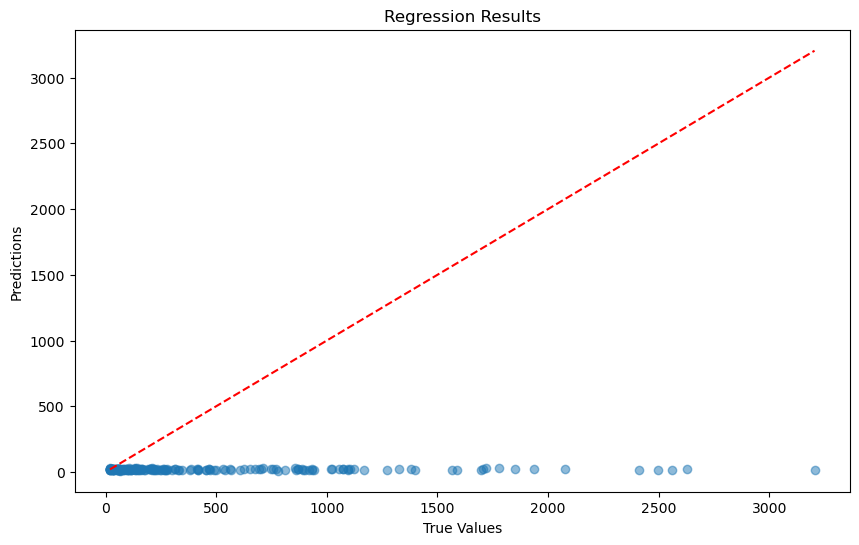

In [20]:
def plot_regression_results(model, dataloader):
    model.eval()
    y_true = []
    y_pred = []
    with torch.no_grad():
        for batch in dataloader:
            x, y = batch
            y_hat = torch.tensor(model.neural_network.target_scaler.inverse_transform(model(x).numpy()))
            y_true.append(torch.tensor(model.neural_network.target_scaler.inverse_transform(y.numpy())))
            y_pred.append(y_hat)

    y_true = torch.cat(y_true).numpy()
    y_pred = torch.cat(y_pred).numpy()

    plt.figure(figsize=(10, 6))
    plt.scatter(y_true, y_pred, alpha=0.5)
    plt.plot([y_true.min(), y_true.max()], [y_true.min(), y_true.max()], 'r--')
    plt.xlabel('True Values')
    plt.ylabel('Predictions')
    plt.title('Regression Results')
    plt.show()
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())

In [21]:
import optuna

trial_to_details = {}
def objective(trial):
    # Sample hyperparameters
    activation_dict = {
        "relu": nn.ReLU,
        "leaky_relu": nn.LeakyReLU,
        "tanh": nn.Tanh,
        "RReLU": nn.RReLU,
    }
    optimizer_dict = {
        "adam": torch.optim.Adam,
        "sgd": torch.optim.SGD,
        "adagrad": torch.optim.Adagrad,
    }
    n_layers = trial.suggest_int("n_layers", 3, 15)
    dropout = trial.suggest_float("dropout", 0.0, 0.5)
    learning_rate = trial.suggest_float("learning_rate", 1e-5, 1e-2, log=True)
    weight_decay = trial.suggest_float("weight_decay", 1e-5, 1e-2, log=True)
    optimizer = trial.suggest_categorical("optimizer", list(optimizer_dict.keys()))
    activation = trial.suggest_categorical("activation", list(activation_dict.keys()) )

    activation = activation_dict[activation]
    optimizer = optimizer_dict[optimizer]

    model = BaseCancerRegressor(
        CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=n_layers,
            dropout=dropout,
            activation=activation,
            target_scaler=target_scaler,
        ),
        lr=learning_rate,
        weight_decay=weight_decay,
        optimizer=optimizer,
    )
    trainer, logger, checkpoint = create_classifier_trainer(f"trial_{trial.number}", max_epochs=100, enable_pbar=False)


    # Training loop
    trainer.fit(
        model,
        datamodule=CancerDataModule(cancer_df, numerical_features=numeric_cols, scaler=scaler, target_scaler=target_scaler),
    )
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }

    
    # Store trial details
    trial_to_details[trial.number] = {
        "logger" : logger,
        "checkpoint" : checkpoint,
    }
    metrics_path = f"{logger.log_dir}/metrics.csv"
    metrics_df = pd.read_csv(metrics_path)

    if "val_mse" not in metrics_df.columns:
        return float("inf")

    last_val = metrics_df["val_mse"].dropna().values[-1]
    return last_val

In [ ]:
# --- Run Optuna ---
study = optuna.create_study(direction="minimize", study_name="ae_regressor_scaled_study")
study.optimize(objective, n_trials=100, n_jobs=1, show_progress_bar=True)

# --- Print Best Result ---
print("Best trial:")
print(f"  Value (val_mse): {study.best_trial.value}")
print("  Params:")
for key, val in study.best_trial.params.items():
    print(f"    {key}: {val}")

[I 2025-04-17 12:22:45,454] A new study created in memory with name: ae_regressor_scaled_study


  0%|          | 0/100 [00:00<?, ?it/s]

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 29.9 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
29.9 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.525     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:22:53,958] Trial 0 finished with value: 0.9434814453125 and parameters: {'n_layers': 4, 'dropout': 0.006819017141894201, 'learning_rate': 1.949454986668053e-05, 'weight_decay': 0.0009944428325421798, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 0 with value: 0.9434814453125.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:23:00,937] Trial 1 finished with value: 0.8533397912979126 and parameters: {'n_layers': 10, 'dropout': 0.11664005427409058, 'learning_rate': 0.001597679360304188, 'weight_decay': 3.326321752805012e-05, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 1 with value: 0.8533397912979126.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:23:12,641] Trial 2 finished with value: 0.8602116107940674 and parameters: {'n_layers': 10, 'dropout': 0.40811555838408436, 'learning_rate': 0.0007537557156070148, 'weight_decay': 0.0011686001293433775, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 1 with value: 0.8533397912979126.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 31.6 M | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
31.6 M    Trainable params
101 K     Non-trainable params
31.7 M    Total params
126.753   Total estimated model params size (MB)
86        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:23:23,018] Trial 3 finished with value: 0.93423593044281 and parameters: {'n_layers': 15, 'dropout': 0.2652536697143848, 'learning_rate': 0.00018507514680125205, 'weight_decay': 8.134951516687293e-05, 'optimizer': 'sgd', 'activation': 'leaky_relu'}. Best is trial 1 with value: 0.8533397912979126.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 124 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
124 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.903     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:23:30,437] Trial 4 finished with value: 0.8626776337623596 and parameters: {'n_layers': 7, 'dropout': 0.43289955476035535, 'learning_rate': 8.165197852273437e-05, 'weight_decay': 0.000601115924392339, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 1 with value: 0.8533397912979126.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.028    Total estimated model params size (MB)
74        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:23:46,026] Trial 5 finished with value: 0.8530164361000061 and parameters: {'n_layers': 12, 'dropout': 0.20800182530597278, 'learning_rate': 0.00017811260270674513, 'weight_decay': 0.00013881996708885085, 'optimizer': 'adam', 'activation': 'tanh'}. Best is trial 5 with value: 0.8530164361000061.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.329     Total estimated model params size (MB)
70        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:23:57,689] Trial 6 finished with value: 0.8125359416007996 and parameters: {'n_layers': 11, 'dropout': 0.35313916716552657, 'learning_rate': 0.007377310473099969, 'weight_decay': 0.0021920022132719554, 'optimizer': 'adagrad', 'activation': 'relu'}. Best is trial 6 with value: 0.8125359416007996.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 2.0 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
2.0 M     Trainable params
101 K     Non-trainable params
2.1 M     Total params
8.326     Total estimated model params size (MB)
66        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:24:05,835] Trial 7 finished with value: 0.8968642950057983 and parameters: {'n_layers': 10, 'dropout': 0.2950663386025199, 'learning_rate': 0.0006306368390684317, 'weight_decay': 0.00019864088879100814, 'optimizer': 'sgd', 'activation': 'tanh'}. Best is trial 6 with value: 0.8125359416007996.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 29.9 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
29.9 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.525     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:24:22,878] Trial 8 finished with value: 0.8120988607406616 and parameters: {'n_layers': 4, 'dropout': 0.3903095902714868, 'learning_rate': 1.3495663763993526e-05, 'weight_decay': 0.005550391880194209, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 8 with value: 0.8120988607406616.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 7.9 M  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
7.9 M     Trainable params
101 K     Non-trainable params
8.0 M     Total params
32.032    Total estimated model params size (MB)
78        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:24:33,943] Trial 9 finished with value: 1.049202799797058 and parameters: {'n_layers': 13, 'dropout': 0.16755310167474108, 'learning_rate': 0.00011911507505243828, 'weight_decay': 0.006495967369387505, 'optimizer': 'adam', 'activation': 'relu'}. Best is trial 8 with value: 0.8120988607406616.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 6.9 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
6.9 K     Trainable params
101 K     Non-trainable params
108 K     Total params
0.433     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:24:42,409] Trial 10 finished with value: 0.7994317412376404 and parameters: {'n_layers': 3, 'dropout': 0.48006723714847627, 'learning_rate': 1.0813437821366036e-05, 'weight_decay': 0.007906302345830497, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 6.9 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
6.9 K     Trainable params
101 K     Non-trainable params
108 K     Total params
0.433     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:24:55,292] Trial 11 finished with value: 0.8220027685165405 and parameters: {'n_layers': 3, 'dropout': 0.4991506118816279, 'learning_rate': 1.0220823707061493e-05, 'weight_decay': 0.004892073797237702, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 123 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
123 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.900     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:25:03,608] Trial 12 finished with value: 0.809962272644043 and parameters: {'n_layers': 6, 'dropout': 0.49918400711635547, 'learning_rate': 3.180910622031884e-05, 'weight_decay': 0.0078694711042698, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 124 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
124 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.903     Total estimated model params size (MB)
54        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:25:12,183] Trial 13 finished with value: 0.8280232548713684 and parameters: {'n_layers': 7, 'dropout': 0.47025895027115533, 'learning_rate': 4.2571110279306936e-05, 'weight_decay': 0.009599961488899031, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 123 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
123 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.900     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:25:20,537] Trial 14 finished with value: 0.8475417494773865 and parameters: {'n_layers': 6, 'dropout': 0.3408836860052154, 'learning_rate': 3.089821688982821e-05, 'weight_decay': 1.1476536354775723e-05, 'optimizer': 'adagrad', 'activation': 'RReLU'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 123 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
123 K     Trainable params
101 K     Non-trainable params
225 K     Total params
0.900     Total estimated model params size (MB)
50        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:25:33,165] Trial 15 finished with value: 0.8292518258094788 and parameters: {'n_layers': 6, 'dropout': 0.4924644394346834, 'learning_rate': 5.619527970763159e-05, 'weight_decay': 0.0027888716879433013, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 6.9 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
6.9 K     Trainable params
101 K     Non-trainable params
108 K     Total params
0.433     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:25:41,230] Trial 16 finished with value: 0.8949408531188965 and parameters: {'n_layers': 3, 'dropout': 0.43665157881283334, 'learning_rate': 2.839363743806102e-05, 'weight_decay': 0.00040270765263104917, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 30.7 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
30.7 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.528     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:25:54,528] Trial 17 finished with value: 0.8965016007423401 and parameters: {'n_layers': 5, 'dropout': 0.3322541503810571, 'learning_rate': 1.2141724863006638e-05, 'weight_decay': 0.0024932193905100397, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
597 K     Total params
2.390     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:26:03,360] Trial 18 finished with value: 0.8400874137878418 and parameters: {'n_layers': 8, 'dropout': 0.06937118323082514, 'learning_rate': 0.0037168329720387765, 'weight_decay': 0.009884357218363893, 'optimizer': 'adam', 'activation': 'RReLU'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 30.7 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
30.7 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.528     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:26:11,810] Trial 19 finished with value: 0.8371884822845459 and parameters: {'n_layers': 5, 'dropout': 0.38650410525023504, 'learning_rate': 0.0005068980922291373, 'weight_decay': 0.0011695926407715262, 'optimizer': 'adagrad', 'activation': 'leaky_relu'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 496 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
496 K     Trainable params
101 K     Non-trainable params
597 K     Total params
2.390     Total estimated model params size (MB)
58        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:26:21,136] Trial 20 finished with value: 0.8167811036109924 and parameters: {'n_layers': 8, 'dropout': 0.44747477031785476, 'learning_rate': 6.751498405356772e-05, 'weight_decay': 0.003581722451374933, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 29.9 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
29.9 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.525     Total estimated model params size (MB)
42        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:26:30,356] Trial 21 finished with value: 0.8570951223373413 and parameters: {'n_layers': 4, 'dropout': 0.37678533477503107, 'learning_rate': 1.792512015937935e-05, 'weight_decay': 0.005135683503443019, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 6.9 K  | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
6.9 K     Trainable params
101 K     Non-trainable params
108 K     Total params
0.433     Total estimated model params size (MB)
38        Modules in train mode
0         Modules in eval mode


[I 2025-04-17 12:26:47,112] Trial 22 finished with value: 0.8476845622062683 and parameters: {'n_layers': 3, 'dropout': 0.45430209841391483, 'learning_rate': 1.8164697609797187e-05, 'weight_decay': 0.0021294819079090677, 'optimizer': 'sgd', 'activation': 'relu'}. Best is trial 10 with value: 0.7994317412376404.


GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name           | Type                  | Params | Mode 
-----------------------------------------------------------------
0 | auto_encoder   | CancerDataAutoEncoder | 101 K  | train
1 | neural_network | SimpleNN              | 30.7 K | train
2 | loss_metric    | MeanSquaredError      | 0      | train
3 | val_metric     | MeanSquaredError      | 0      | train
4 | test_metric    | MeanSquaredError      | 0      | train
-----------------------------------------------------------------
30.7 K    Trainable params
101 K     Non-trainable params
131 K     Total params
0.528     Total estimated model params size (MB)
46        Modules in train mode
0         Modules in eval mode


In [ ]:
best_model_logger = trial_to_details[study.best_trial.number]["logger"]

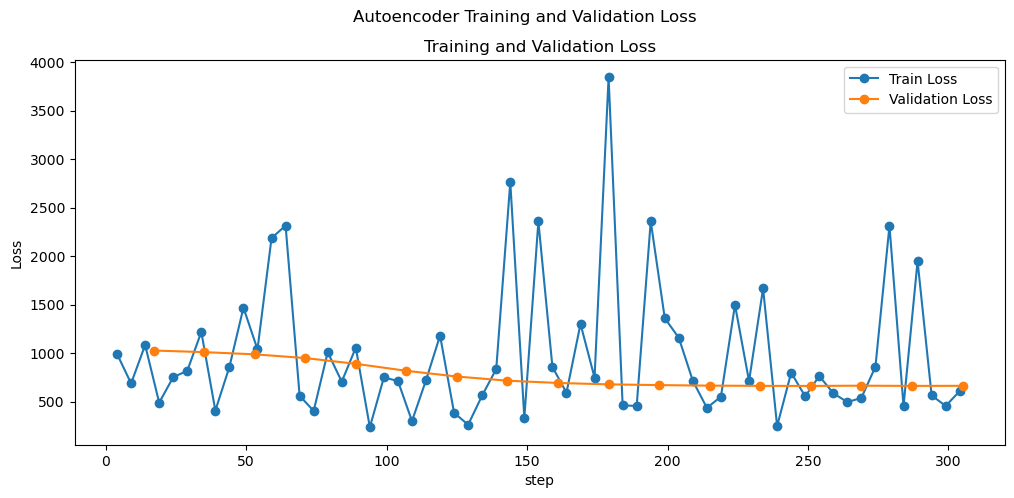

In [ ]:
from utils.helper_functions import make_plots


history = pd.read_csv(best_model_logger.log_dir + "/metrics.csv")
make_plots(history, "Autoencoder Training and Validation Loss")

In [ ]:
best_model_path = trial_to_details[study.best_trial.number]["checkpoint"].best_model_path
!cp {best_model_path} results/05/best_model.pth

In [ ]:
activation_dict = {
    "relu": nn.ReLU,
    "leaky_relu": nn.LeakyReLU,
    "tanh": nn.Tanh,
    "RReLU": nn.RReLU,
}
optimizer_dict = {
    "adam": torch.optim.Adam,
    "sgd": torch.optim.SGD,
    "adagrad": torch.optim.Adagrad,
}

best_model = BaseCancerRegressor.load_from_checkpoint(
    trial_to_details[study.best_trial.number]["checkpoint"].best_model_path,
    auto_encoder=CancerDataAutoEncoder.load_from_checkpoint(
            best_ae_model_path,
            **best_model_params
        ),
        neural_network=SimpleNN(
            input_dim=best_model_params['latent_size'],
            n_layers=study.best_trial.params['n_layers'],
            dropout=study.best_trial.params['dropout'],
            activation=activation_dict[study.best_trial.params['activation']],
            target_scaler=target_scaler,
        ),
        lr=study.best_trial.params['learning_rate'],
        weight_decay=study.best_trial.params['weight_decay'],
        optimizer=optimizer_dict[study.best_trial.params['optimizer']],
    
)
best_model

BaseCancerRegressor(
  (auto_encoder): CancerDataAutoEncoder(
    (encoder): Sequential(
      (0): Linear(in_features=203, out_features=121, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.08362845598146633, inplace=False)
      (3): Linear(in_features=121, out_features=39, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.08362845598146633, inplace=False)
      (6): Linear(in_features=39, out_features=38, bias=True)
    )
    (decoder): Sequential(
      (0): Linear(in_features=38, out_features=120, bias=True)
      (1): ReLU()
      (2): Dropout(p=0.08362845598146633, inplace=False)
      (3): Linear(in_features=120, out_features=202, bias=True)
      (4): ReLU()
      (5): Dropout(p=0.08362845598146633, inplace=False)
      (6): Linear(in_features=202, out_features=203, bias=True)
    )
    (loss_metric): MeanSquaredError()
    (val_metric): MeanSquaredError()
    (test_metric): MeanSquaredError()
  )
  (neural_network): SimpleNN(
    (network): Sequential(
      (0): Linear(

In [ ]:
joblib.dump(
    best_model,
    f"results/05/best_model_trial_ae_scaled_{study.best_trial.number}.pkl",
)

['results/03/best_model_trial_ae_84.pkl']

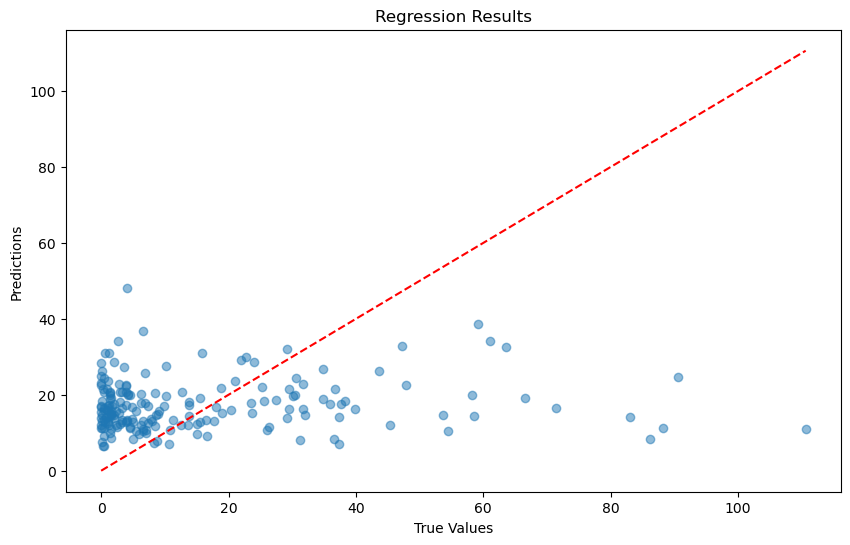

In [ ]:
plot_regression_results(cancer_regressor, cancer_dm.test_dataloader())